# Jupyter Notebook Workflow

1. Data curation and clean up
2. Run Nonadditivity Analysis
3. Generate Plots


In [1]:
import rdkit
from rdkit import Chem
from rdkit import Geometry
from rdkit import rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MolStandardize
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize.standardize import canonicalize_tautomer_smiles
from rdkit.Chem import rdFMCS
rdBase.DisableLog('rdApp.info')

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from scipy.stats import normaltest
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import multiprocessing as mp
from multiprocessing import Process, Pipe


### Set path for reading and writing data

In [2]:
my_path = './naa/ChEMBL_1614027/'
my_name = 'ChEMBL_1614027'

# <font color='crimson'>STEP I</font>

# Data Curation

* Data example for ChEMBL1614027

In [3]:
data = pd.read_csv(my_path+'ChEMBL_1614027.gz', compression='gzip', header=0, sep=';', error_bad_lines=False)

### Rearrange columns and keep the ones necessary

In [4]:
def rearrange(df):
    df = df.rename(columns=({'Molecule ChEMBL ID':'COMPOUND_NAME', 'Smiles': 'SMILES', 'Standard Value': 'VALUE', 'Standard Value' : 'VALUE', 'Standard Units': 'UNIT', 'Standard Type': 'ENDPOINT'}))
    df = df[['SMILES', 'COMPOUND_NAME', 'ENDPOINT', 'Standard Relation', 'VALUE', 'UNIT']]
    
    return df

###  Remove NaNs from SMILES column

In [5]:
def discard_nan_smiles(df):
    df = df.dropna(subset = ['SMILES'])
    
    return(df)

### Deleting uncertain values

In [6]:
def discard_uncertain_values(df):
    df = df[df['Standard Relation'] != "'>'"]
    df = df[df['Standard Relation'] != "'<'"]
    df['VALUE'] = df['VALUE'].astype(float)
    df = df[df['VALUE'] > 0] #in case one needs to delete negative values
    df = df.drop(columns=['Standard Relation'])

    return(df)

### Converting values to logged ones

In [7]:
unit_conversion = {
    'M': 1,
    'mM': 1000,
    'uM': 1000000,
    'nM': 1000000000,
    'pM': 1000000000000,
    'fM': 1000000000000000    
}

def log_converstion(x, UNIT):
    if UNIT not in unit_conversion:
        return x
    x= -1 * np.log10(x / unit_conversion[UNIT])
    return x

def create_conversion_column(df):
    arr = [log_converstion(x['VALUE'], x['UNIT']) for idx, x in df.iterrows()]

    df['NEW_VALUE'] = arr
    df = df[df['NEW_VALUE'] > 0]
    df = df.drop(columns=['VALUE'])
    
    # deleting the values that are more than 10 mM and less than 1 fM
    
    df = df[df['NEW_VALUE'] > 2]
    df = df[df['NEW_VALUE'] < 11]
    
    return df

### Calculating the avarage of the activity and calculating the median

In [8]:
def calculate_average(df):
    df['Median_Value'] = df.groupby(['COMPOUND_NAME'])['NEW_VALUE'].transform('median')
    df['max_value'] = df.groupby(['COMPOUND_NAME'])['NEW_VALUE'].transform('max')
    df['min_value'] = df.groupby(['COMPOUND_NAME'])['NEW_VALUE'].transform('min')
    df['difference'] = df.max_value - df.min_value
    
    df = df.drop_duplicates(subset=['COMPOUND_NAME'], keep= 'first')

    return(df)

### Delete compounds that have been measured several times in one test and differ more than 2.5 log units

In [9]:
def discard_ambiguous_compound_measurements(df, max_thrs = 2.5):
    
    df = df[df.difference < max_thrs]  
    
    df = df[['SMILES', 'COMPOUND_NAME', 'ENDPOINT', 'Median_Value', 'MEASUREMENT']]
    df = df.rename(columns=({'Median_Value':'VALUE'}))
    
    return(df)

### Standardize molecules using RDkit

In [10]:
def standardize_rdkit(row, col):
    smi = row[col]

    try:
        mol = Chem.MolFromSmiles(smi)   # sanitization is done by default
        fmol = rdMolStandardize.FragmentParent(mol)   # returns largest fragment
        cmol = rdMolStandardize.ChargeParent(fmol)   # uncharges the largest fragment
        smi = Chem.MolToSmiles(cmol)   
        ssmi = MolStandardize.canonicalize_tautomer_smiles(smi)   # returns the canonicalized tautomer
        tsmi = MolStandardize.rdMolStandardize.StandardizeSmiles(ssmi)   # standardize 
    except:
        tsmi = 'none'
    
    return tsmi

In [11]:
def generateStandarizedSmiles(smilesfile, smiles_column):

    pool = mp.Pool(8)   # set number of cores for parallelization
    stsmi_list = pool.starmap(standardize_rdkit, [(smi, smiles_column) for idx, smi in smilesfile.iterrows()])
    pool.close()
    
    smilesfile[smilesfile.columns[smiles_column]] = stsmi_list

    return (smilesfile)

### Discard duplicate SMILES

- Keep the one with the highest value, i.e. most active one

In [12]:
def merge_duplicate_smiles(df):
    df = df.sort_values('VALUE').drop_duplicates(subset=['SMILES'], keep='last') 
    
    return(df)

### Remove molecules with > 70 heavy atoms

In [13]:
def discarding_heavy_mols(smi, min_size = 0, max_size = 70):
    try:
        mol = Chem.MolFromSmiles(smi, sanitize=False)
        if min_size <= mol.GetNumHeavyAtoms() <= max_size:
            return False
        else:
            return True
    except:
        return True 
    
def removeHeavyMols(df, smiles_column):
    idx = []
    discard = []
    for index, row in df.iterrows():
    #for smi in df.iloc[:,smiles_column]:
        if discarding_heavy_mols(row[smiles_column]):
            idx.append(index)
            discard.append(row.values.tolist())

    df.drop(idx, inplace=True)
    return (df)

### Apply all of the above functionalities and safe file

In [14]:
df = rearrange(data)
print('#cmpds: ', len(df['COMPOUND_NAME']))
print('#unique cmpds: ', len(df['COMPOUND_NAME'].value_counts()))

# Counting how many times compounds were measured in tests
df['MEASUREMENT'] = df.groupby(['COMPOUND_NAME'])['COMPOUND_NAME'].transform('count')

# Discard cmpds without SMILES
df = discard_nan_smiles(df)
print('#cpds with SMILES: ', len(df.iloc[:,0]))

# Discard ambiguous data
df = discard_uncertain_values(df)
print('#cpds with values: ', len(df.iloc[:,0]))

# Convert IC50 to pIC50
df = create_conversion_column(df) 

# Calculate average values and discard cpds with > 2.5 log unit measurement differences
df = calculate_average(df)
df = discard_ambiguous_compound_measurements(df)
print('#cpds after merging multi measurements: ', len(df.iloc[:,0]))

# standardize SMILES, merge duplicates and retain higher active one
smiles_column = 0
df = generateStandarizedSmiles(df, smiles_column)
df = df[df['SMILES'] != 'none']
df = merge_duplicate_smiles(df)
print('#cpds after merging duplicate SMILES: ', len(df.iloc[:,0]))

# Remove cpds with > 70 HA
smiles_column = 0
df = removeHeavyMols(df, smiles_column)
print('#cpds < 70 HA: ', len(df.iloc[:,0]))

# Rename columns for subsequent NAA
df = df.rename(columns=({'COMPOUND_NAME':'ID'}))
df = df[['ID', 'SMILES', 'VALUE', 'MEASUREMENT']]

# safe file
df.to_csv(my_path+my_name+'_curated.csv', index = False)

#cmpds:  3082
#unique cmpds:  2933
#cpds with SMILES:  3047
#cpds with values:  3047
#cpds after merging multi measurements:  2893


RDKit ERROR: [17:00:49] Can't kekulize mol.  Unkekulized atoms: 0 3 6
RDKit ERROR: 
RDKit ERROR: [17:00:49] Can't kekulize mol.  Unkekulized atoms: 0 3 6
RDKit ERROR: 
RDKit ERROR: [17:00:49] Can't kekulize mol.  Unkekulized atoms: 0 3 6
RDKit ERROR: 
RDKit ERROR: [17:00:49] Can't kekulize mol.  Unkekulized atoms: 0 3 6
RDKit ERROR: 
RDKit ERROR: [17:00:49] Can't kekulize mol.  Unkekulized atoms: 0 3 6
RDKit ERROR: 
RDKit ERROR: [17:00:49] Can't kekulize mol.  Unkekulized atoms: 0 3 6
RDKit ERROR: 


#cpds after merging duplicate SMILES:  2877
#cpds < 70 HA:  2876


# <font color='crimson'>  STEP II

# NAA

- Code available from gitHub by Christian Kramer: https://github.com/KramerChristian/NonadditivityAnalysis
- Corresponoding publication: https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00631

In order to run NAA out of the jupyter notebook, the system variable for the NAA path has to be set.

If this is not done automatically, do the following in your commandline (Linux):
> cd $CONDA_PREFIX

> mkdir -p ./etc/conda/activate.d

> mkdir -p ./etc/conda/deactivate.d

> touch ./etc/conda/activate.d/env_vars.sh

> touch ./etc/conda/deactivate.d/env_vars.sh

- change activate.d/env_vars.sh
> export NNA=/path/to/nna/
- change deactivate.d/env_vars.sh
> unset NNA

In [15]:
def init_naa():
    # save system variable in a local python variable, otherwise the !python call doesn't work
    naapath = !echo $NAA
    naapath = naapath[0]
    
    return naapath

In [42]:
def naa(infile, outfile, myprops, myunit, mydelim='comma', myseries='', naapath=init_naa()):
    print ("\nanalyzing: ", infile)

    if (myseries != '') :
        print ('\n\n', naapath+'Nonadditivity_Analysis.py -in ', infile ,' -delimiter ', mydelim , ' -series_column ', myseries, ' -props ', myprops ,' -units ', myunit ,' -out ', outfile, '\n\n')
        !python {naapath}/Nonadditivity_Analysis.py -in {infile} -delimiter {mydelim} -series_column {myseries} -props {myprops} -units {myunit} -out {outfile}
    else:    
        print ('\n\n', naapath+'Nonadditivity_Analysis.py -in ', infile ,' -delimiter ', mydelim ,' -props ', myprops ,' -units ', myunit ,' -out ', outfile, '\n\n')
        !python {naapath}/Nonadditivity_Analysis.py -in {infile} -delimiter {mydelim} -props {myprops} -units {myunit} -out {outfile}
    
    print ("Done analysing.\n")
    return outfile

### Run NAA on cleanup data set

In [43]:
infile = my_path+my_name+'_curated.csv'
outfile = my_path+my_name+'_NAA_output.csv'

naa(infile, outfile, 'VALUE', 'noconv', 'comma')


analyzing:  ./naa/ChEMBL_1614027/ChEMBL_1614027_curated.csv
Identifier Column found: ID
Smiles column found: SMILES
Activity column #1: VALUE
Generating MMP Fragments for ./naa/ChEMBL_1614027/ChEMBL_1614027_curated.csv
Indexing MMP Fragments for ./naa/ChEMBL_1614027/ChEMBL_1614027_curated.csv
Analyzing neighborhoods                
Assembling circles
Writing Output.
Estimated Experimental Uncertainty
for property:  VALUE
based on  4086  cycles.
0.36  from normal SD
0.30  from MAD
0.30  from Median of Medians

Done analysing.



'./naa/ChEMBL_1614027/ChEMBL_1614027_NAA_output.csv'

# <font color='crimson'> STEP III

### Generate plots for analysing NAA output

In [18]:
curated = my_path+my_name+'_curated.csv'
curated = pd.read_csv(curated, sep=',')

###  <font color='crimson'> * adjust thresholds based on the experimental uncertainty
    
- Experimental uncertainty estimates can be derived from NAA 

In [19]:
add_thrs = 0
exp_noise = 0.5
significant_thrs = 2*exp_noise
strong_thrs = 2*significant_thrs

In [20]:
MAIN = my_path+my_name+'_NAA_output.csv'
MAIN = pd.read_csv(MAIN, sep='\t')

MAIN['Nonadditivity_abs'] = MAIN['Nonadditivity'].abs()
MAIN_log0 = MAIN[MAIN['Nonadditivity_abs'] > add_thrs]
MAIN_log1 = MAIN[MAIN['Nonadditivity_abs'] > significant_thrs]
MAIN_log2 = MAIN_log1[MAIN_log1['Nonadditivity_abs'] > strong_thrs]

In [21]:
PC = my_path+my_name+'_NAA_output_perCompound.txt'
PC = pd.read_csv(PC, sep='\t')

PC['Nonadd_abs'] = PC['Nonadd_pC'].abs()
PC['CI'] = (2*2*exp_noise/(np.sqrt(PC['nOccurence'])))
PC['CI_2'] = (2*2*exp_noise/(np.sqrt(PC['nOccurence'])))*3
PC = PC.sort_values(by=['CI'], ascending=False)

PC_log0 = PC[PC['Nonadd_abs'] > add_thrs]
PC_log1 = PC[PC['Nonadd_abs'] > significant_thrs]
PC_log2 = PC_log1[PC_log1['Nonadd_abs'] > strong_thrs]

In [22]:
print(len(curated.iloc[:,0]), 'compounds')
print(len(MAIN.iloc[:,0]), 'cycles')
print(len(MAIN_log1.iloc[:,0]), 'cycles with significant NA score', '(',round(len(MAIN_log1.iloc[:,0])/len(MAIN.iloc[:,0])*100,1), '% )')
print(len(PC_log1['Compound_ID'].value_counts()), 'unique compounds show significant NA shift', '(',round(len(PC_log1['Compound_ID'])/len(curated.iloc[:,0])*100,1), '% )')
print(len(PC_log2['Compound_ID'].value_counts()), 'unique compounds show strong NA', '(',round(len(PC_log2['Compound_ID'])/len(curated.iloc[:,0])*100,1), '% )')

2876 compounds
4086 cycles
486 cycles with significant NA score ( 11.9 % )
76 unique compounds show significant NA shift ( 2.6 % )
13 unique compounds show strong NA ( 0.5 % )


### Check for normality 

In [23]:
MAIN_array = MAIN['Nonadditivity'].values
stats.describe(MAIN_array, axis=0)

DescribeResult(nobs=4086, minmax=(-4.2, 3.7), mean=-0.008981839302667646, variance=0.5284652015619267, skewness=-0.18666235101379203, kurtosis=3.212527050178692)

In [24]:
stat, p = normaltest(MAIN_array)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=335.764, p=0.000
Sample does not look Gaussian (reject H0)


### Nonadditivity Distribution

<font color='crimson'>normal distribution parameters depend on significant treshold

In [25]:
def NA_distribution(x, hist=True, kde=True, ins=int(100/5), color='crimson', kde_kws={'shade': True, 'linewidth': 2}):
    sns.set_style('ticks')
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10, 8)
    sns.distplot(x, hist=True, kde=True,
             bins=int(100/5), color='crimson',
             kde_kws={'shade': True, 'linewidth': 2})
    sns.distplot(normal_dist, hist=False, kde=True,
             color='grey',
             kde_kws={'shade': True, 'linewidth': 2})

    legend = ['Real','Theoretical']

    plt.legend(legend, prop={'size': 20}) #title = '')
    plt.title('',  size=30)
    plt.xlabel('Nonadditivity',  size=25)
    plt.ylabel('Density',  size=25)
    
    plt.show()

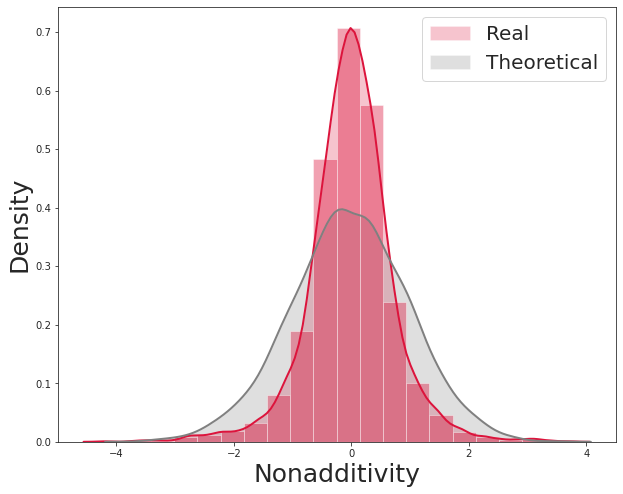

In [26]:
n_of_cycles = len(MAIN.iloc[:,0])
normal_dist = np.random.normal(loc=0,scale=significant_thrs,size=n_of_cycles)

NA_distribution(MAIN['Nonadditivity'])

### Detect outliers

In [27]:
ambiguous_compounds = PC.loc[PC['Nonadd_abs'] > PC['CI']]
print(len(ambiguous_compounds.iloc[:,0]), 'compounds')
outliers = ambiguous_compounds[['SMILES']]

#outliers.to_csv(my_path+'outliers.csv', index = False)

395 compounds


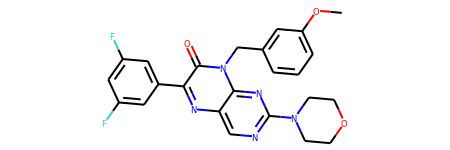

In [28]:
ambiguous_compounds = ambiguous_compounds.sort_values('Nonadd_abs')
SMILES = list(ambiguous_compounds['SMILES'])
strangest = SMILES[-2]

display(Chem.MolFromSmiles(strangest))

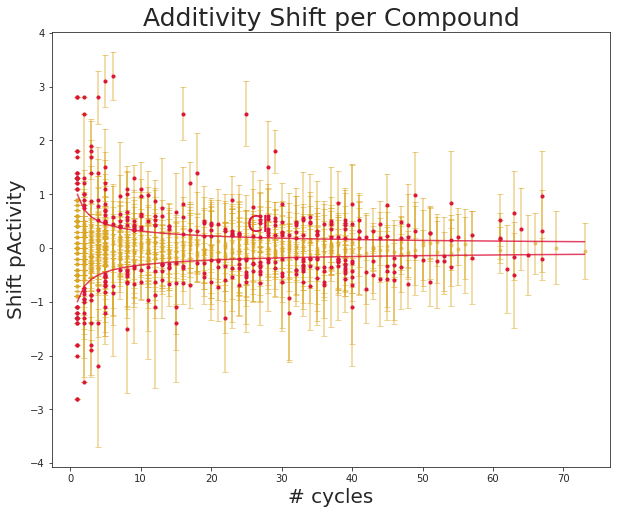

In [29]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('# cycles', fontsize=20)
ax.set_ylabel('Shift pActivity', fontsize=20)
ax.set_title('Additivity Shift per Compound', fontsize=25)

x = PC['nOccurence'].values
y = PC['Nonadd_pC'].values
e = PC['Nonadd_SD'].values
y_CI = PC['CI'].values
y_CI_2 = PC['CI_2'].values
x2 = ambiguous_compounds['nOccurence'].values
y2 = ambiguous_compounds['Nonadd_pC'].values
e2 = ambiguous_compounds['Nonadd_SD'].values

ax.errorbar(x, y, zorder=1, linestyle='None', yerr=e, alpha=0.5, capsize=3, color='goldenrod', marker='.')
ax.plot(x,y_CI, zorder=2, color='crimson', alpha=0.8, label= 'CI')
plt.text(25, 0.3, 'CI', fontsize=23, color='crimson')
ax.plot(x,y_CI*(-1), zorder=3, color='crimson', alpha=0.8)
ax.errorbar(x2, y2, zorder=1, linestyle='None', capsize=3, color='crimson', marker='.')

plt.show()

### Check outliers 

1. value
2. measurement frequency

In [30]:
ambiguous_compounds = ambiguous_compounds[['Compound_ID', 'Measured', 'nOccurence', 'Nonadd_pC']]
ambiguous_compounds = ambiguous_compounds.rename(columns=({'Compound_ID':'ID'}))
ambiguous_compounds = pd.merge(ambiguous_compounds, curated, on='ID')
ambiguous_compounds = ambiguous_compounds[['ID', 'VALUE', 'nOccurence', 'Nonadd_pC']]

In [31]:
my_title = 'Outliers'
def plot_outliers(x, hist=True, kde=True, ins=int(100/5), color='crimson', kde_kws={'shade': True, 'linewidth': 2}):
    sns.set_style('ticks')
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10, 8)
    sns.distplot(x, hist=True, kde=True,
                 bins=int(100/5), color='crimson',
                 kde_kws={'shade': True, 'linewidth': 2})

    plt.title(my_title,  size=30)
    plt.xlabel('pActivity Value',  size=25)
    plt.ylabel('Density',  size=25)

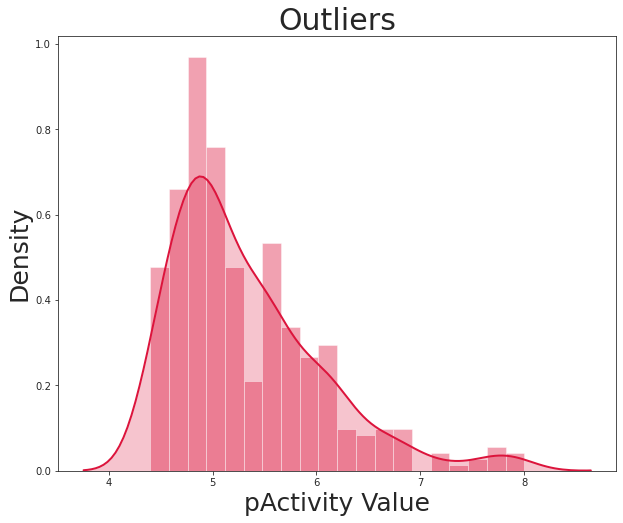

In [32]:
plot_outliers(ambiguous_compounds['VALUE'])

### Compounds with Significant Additivity Shift
* significant = 2 times the experimental uncertainty

In [33]:
sign_NA_PC = PC_log1[['Compound_ID', 'Nonadd_pC']]
sign_NA_PC = sign_NA_PC.rename(columns=({'Compound_ID':'ID'}))
sign_NA_PC = pd.merge(sign_NA_PC, curated, on='ID')
sign_NA_PC = sign_NA_PC[['ID', 'VALUE', 'Nonadd_pC']]

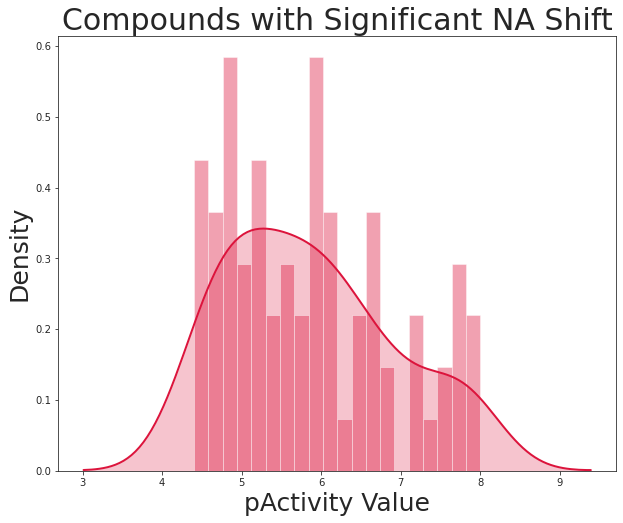

In [34]:
my_title = 'Compounds with Significant NA Shift'
plot_outliers(sign_NA_PC['VALUE'])

Text(0, 0.5, '# Compounds')

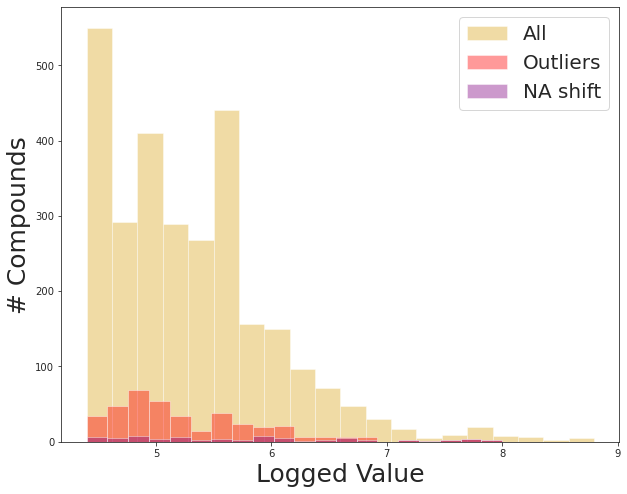

In [35]:
sns.set_style('ticks')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 8)
sns.distplot(curated['VALUE'], hist=True, norm_hist=False, kde=False,
             bins=int(100/5), color='goldenrod',
             kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(ambiguous_compounds['VALUE'], hist=True, norm_hist=False, kde=False,
             color='red', bins=int(100/5),
             kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(sign_NA_PC['VALUE'], hist=True, norm_hist=False, kde=False,
             bins=int(100/5), color='purple',
             kde_kws={'shade': True, 'linewidth': 2})

legend = ['All','Outliers', 'NA shift']

plt.legend(legend, prop={'size': 20}) #title = '')
plt.title('',  size=30)
plt.xlabel('Logged Value',  size=25)
plt.ylabel('# Compounds',  size=25)

### Compounds with strong nonadditivity shift

* more than 2 times significance threshold

In [36]:
strong_NA_PC = PC_log2[['Compound_ID', 'Nonadd_pC']]
strong_NA_PC = strong_NA_PC.rename(columns=({'Compound_ID':'ID'}))
strong_NA_PC = pd.merge(strong_NA_PC, df, on='ID')
strong_NA_PC = strong_NA_PC[['ID', 'VALUE', 'Nonadd_pC', 'MEASUREMENT']]

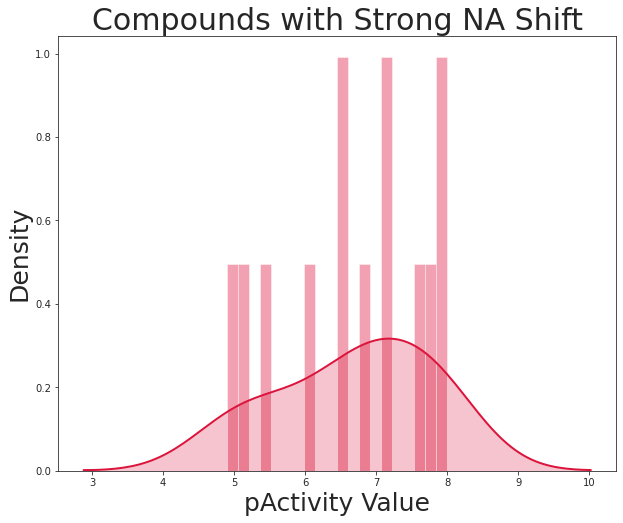

In [37]:
my_title = 'Compounds with Strong NA Shift'
plot_outliers(strong_NA_PC['VALUE'])

### Double-mutant cycles

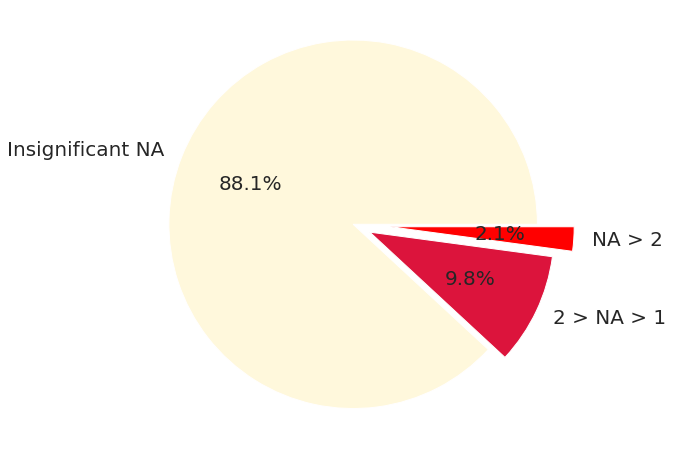

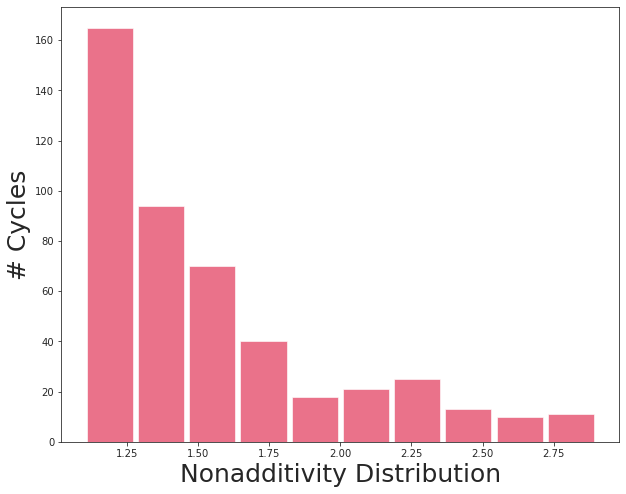

In [38]:
insignificant = len(MAIN.iloc[:,0]) - len(MAIN_log1.iloc[:,0])
treashold_1 = len(MAIN_log1.iloc[:,0]) - len(MAIN_log2.iloc[:,0])
treashold_2 = len(MAIN_log2.iloc[:,0])
labels = ["Insignificant NA", "2 > NA > 1", "NA > 2"]   
sizes = [insignificant, treashold_1, treashold_2]
explode = [0,0.1,0.2]
colors = ['cornsilk', 'crimson', 'red']  
fig = plt.figure(figsize = (8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 20})
plt.axis('equal')
plt.show()

hist = MAIN_log1[MAIN_log1['Nonadditivity_abs'] < 3]

ax = hist.hist(column= 'Nonadditivity_abs', bins=10, figsize=(10,8), color='crimson', alpha=0.6, zorder=10, rwidth=0.9)

ax = ax[0]
for x in ax:
    x.grid(alpha=0)
    x.set_title("", size=25)
    x.set_xlabel("Nonadditivity Distribution", size=25)
    x.set_ylabel("# Cycles", size=25)

### NAA per compound

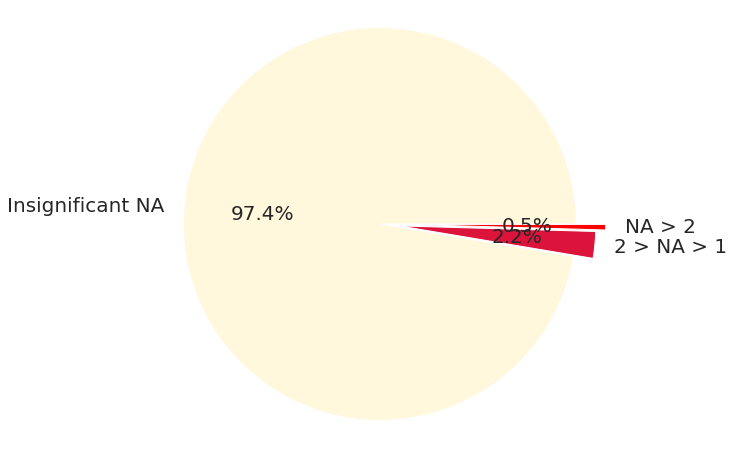

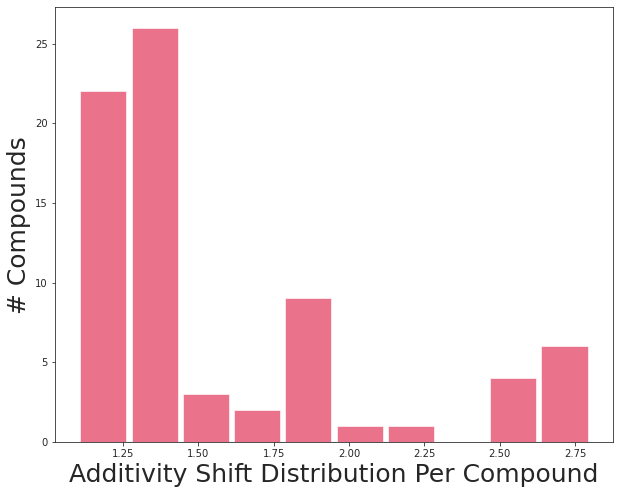

In [39]:
No_NA = len(curated['ID'].value_counts()) - len(PC['Compound_ID'].value_counts())
No_significant =  len(PC['Compound_ID'].value_counts()) - len(PC_log1['Compound_ID'].value_counts()) + No_NA
treashold_1 = len(PC_log1['Compound_ID'].value_counts()) - len(PC_log2['Compound_ID'].value_counts())
treashold_2 = len(PC_log2['Compound_ID'].value_counts())

labels = ["Insignificant NA", "2 > NA > 1", "NA > 2"]   
sizes = [No_significant, treashold_1, treashold_2]
colors = ['cornsilk', 'crimson', 'red']
explode = [0,0.1,0.15]

fig = plt.figure(figsize = (8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 20})
plt.axis('equal')
plt.show()

PC_hist = PC_log1[PC_log1['Nonadd_abs'] < 3]

ax = PC_hist.hist(column= 'Nonadd_abs', bins=10, figsize=(10,8), color='crimson', alpha=0.6, zorder=10, rwidth=0.9)

ax = ax[0]
for x in ax:
    x.grid(alpha=0)
    x.set_title("", size=25)
    x.set_xlabel("Additivity Shift Distribution Per Compound", size=25)
    x.set_ylabel("# Compounds", size=25)

### Plot images of highest NA score

* Code taken from https://github.com/KramerChristian/NonadditivityAnalysis

In [40]:
def draw_image(ids, smiles, tsmarts, pActs, Acts, qualifiers, nonadd, mcss_tot, image_file, target=''):
    """
    Draw Nonadditivity Circle to Image file
    """
    
    cpds = [Chem.MolFromSmiles(i) for i in smiles]

    #########
    # Compute Coordinates of local MCSS, aligned with global MCSS
    
    mcss_loc = Chem.MolFromSmarts(rdFMCS.FindMCS(cpds, completeRingsOnly=True, timeout=60).smartsString)
    Chem.GetSymmSSSR(mcss_loc)
    
    if mcss_tot:
        mcss_tot_coords = [mcss_tot.GetConformer().GetAtomPosition(x) for x in range(mcss_tot.GetNumAtoms())]
        coords2D_tot = [Geometry.Point2D(pt.x, pt.y) for pt in mcss_tot_coords]
    
        mcss_match = mcss_loc.GetSubstructMatch(mcss_tot)
    
        coordDict = {}
        for i, coord in enumerate(coords2D_tot):
            coordDict[mcss_match[i]] = coord
        
        AllChem.Compute2DCoords(mcss_loc, coordMap=coordDict)
    else:
        AllChem.Compute2DCoords(mcss_loc)
    
    #########
    # Align circle compounds to local MCSS
    
    matchVs = [x.GetSubstructMatch(mcss_loc) for x in cpds]

    # compute reference coordinates:
    mcss_loc_coords = [mcss_loc.GetConformer().GetAtomPosition(x) for x in range(mcss_loc.GetNumAtoms())]
    coords2D_loc = [Geometry.Point2D(pt.x, pt.y) for pt in mcss_loc_coords]

    # generate coords for the other molecules using the common substructure
    for molIdx in range(4):
        mol = cpds[molIdx]
        coordDict = {}
        for i, coord in enumerate(coords2D_loc):
            coordDict[matchVs[molIdx][i]] = coord
        AllChem.Compute2DCoords(mol, coordMap=coordDict)

    ##########
    # Assemble Image

    qualifiers_inv = ["" for i in range(4)]
    for i in range(4):
        if qualifiers[i] == ">":
            qualifiers_inv[i] = "<"
        elif qualifiers[i] == "<":
            qualifiers_inv[i] = ">"
        else:
            continue

    new_im = Image.new("RGB", size=(650, 670), color=(255, 255, 255, 0))
    if Acts[0] != "":
        new_im.paste(Draw.MolToImage(cpds[0],
                                     size=(300, 300),
                                     legend=ids[0] + "        " + qualifiers_inv[0] + Acts[0] + " ("
                                     + qualifiers[0] + pActs[0] + ")"),
                     (0, 0))
        new_im.paste(Draw.MolToImage(cpds[1],
                                     size=(300, 300),
                                     legend=ids[1] + "        " + qualifiers_inv[1] + Acts[1] + " ("
                                     + qualifiers[1] + pActs[1] + ")"),
                     (350, 0))
        new_im.paste(Draw.MolToImage(cpds[2],
                                     size=(300, 300),
                                     legend=ids[2] + "        " + qualifiers_inv[2] + Acts[2] + " ("
                                     + qualifiers[2] + pActs[2]+")"),
                     (350, 350))
        new_im.paste(Draw.MolToImage(cpds[3],
                                     size=(300, 300),
                                     legend=ids[3] + "        " + qualifiers_inv[3] + Acts[3] + " ("
                                     + qualifiers[3] + pActs[3] + ")"),
                     (0, 350))

        draw = ImageDraw.Draw(new_im)
        #font = ImageFont.truetype(font_path, 14)
        draw.text((260, 330), "Nonadditivity: " + nonadd, fill=(0, 0, 0, 0))#, font=font)

        #font = ImageFont.truetype(font_path, 10)
        if target != '':
            draw.text((10, 650), "[uM]  (-log10[M])  Activity in Assay: " + target, fill=(0, 0, 0, 0))#, font=font)
    else:
        new_im.paste(Draw.MolToImage(cpds[0],
                                     size=(300, 300),
                                     legend=ids[0]+"        "+qualifiers[0]+pActs[0]),
                     (0, 0))
        new_im.paste(Draw.MolToImage(cpds[1],
                                     size=(300, 300),
                                     legend=ids[1]+"        "+qualifiers[1]+pActs[1]),
                     (350, 0))
        new_im.paste(Draw.MolToImage(cpds[2],
                                     size=(300, 300),
                                     legend=ids[2]+"        "+qualifiers[2]+pActs[2]),
                     (350, 350))
        new_im.paste(Draw.MolToImage(cpds[3],
                                     size=(300, 300),
                                     legend=ids[3]+"        "+qualifiers[3]+pActs[3]),
                     (0, 350))

        draw = ImageDraw.Draw(new_im)
        #font = ImageFont.truetype(font_path, 14)
        draw.text((260, 330), "Nonadditivity: " + nonadd, fill=(0, 0, 0, 0))#, font=font)

        #font = ImageFont.truetype(font_path, 10)
        if target != '':
            draw.text((10, 650), "Activity in Assay: " + target, fill=(0, 0, 0, 0))#, font=font)

    # Draw Arrows
    draw.line((300, 150, 350, 150), fill=0, width=2)
    draw.line((340, 145, 350, 150), fill=0, width=2)
    draw.line((340, 155, 350, 150), fill=0, width=2)

    draw.line((300, 500, 350, 500), fill=0, width=2)
    draw.line((340, 495, 350, 500), fill=0, width=2)
    draw.line((340, 505, 350, 500), fill=0, width=2)

    draw.line((150, 300, 150, 350), fill=0, width=2)
    draw.line((145, 340, 150, 350), fill=0, width=2)
    draw.line((155, 340, 150, 350), fill=0, width=2)

    draw.line((500, 300, 500, 350), fill=0, width=2)
    draw.line((495, 340, 500, 350), fill=0, width=2)
    draw.line((505, 340, 500, 350), fill=0, width=2)

    # Add Reaction Parts
    b = Chem.MolFromSmiles(tsmarts[0][:tsmarts[0].index(">")])
    new_im.paste(Draw.MolToImage(b, size=(50, 50)), (300, 90))

    b = Chem.MolFromSmiles(tsmarts[0][tsmarts[0].index(">")+2:])
    new_im.paste(Draw.MolToImage(b, size=(50, 50)), (300, 160))

    b = Chem.MolFromSmiles(tsmarts[0][:tsmarts[0].index(">")])
    new_im.paste(Draw.MolToImage(b, size=(50, 50)), (300, 440))

    b = Chem.MolFromSmiles(tsmarts[0][tsmarts[0].index(">")+2:])
    new_im.paste(Draw.MolToImage(b, size=(50, 50)), (300, 510))

    b = Chem.MolFromSmiles(tsmarts[1][:tsmarts[1].index(">")])
    new_im.paste(Draw.MolToImage(b, size=(50, 50)), (80, 300))

    b = Chem.MolFromSmiles(tsmarts[1][tsmarts[1].index(">")+2:])
    new_im.paste(Draw.MolToImage(b, size=(50, 50)), (170, 300))

    b = Chem.MolFromSmiles(tsmarts[1][:tsmarts[1].index(">")])
    new_im.paste(Draw.MolToImage(b, size=(50, 50)), (430, 300))

    b = Chem.MolFromSmiles(tsmarts[1][tsmarts[1].index(">")+2:])
    new_im.paste(Draw.MolToImage(b, size=(50, 50)), (520, 300))

    new_im.save(image_file)

    return

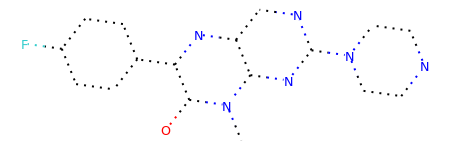

RDKit WARNING: [17:05:21] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [17:05:21] WARNING: not removing hydrogen atom with dummy atom neighbors


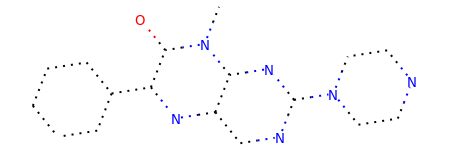

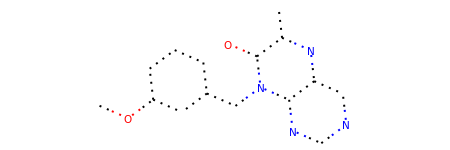

RDKit WARNING: [17:05:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [17:05:23] WARNING: not removing hydrogen atom with dummy atom neighbors


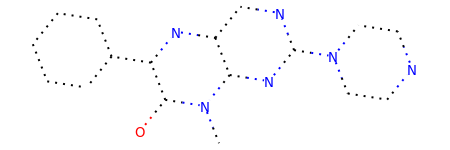

RDKit WARNING: [17:05:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [17:05:23] WARNING: not removing hydrogen atom with dummy atom neighbors


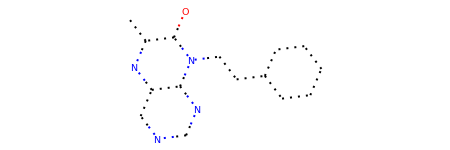

In [41]:
n_images = 5

highest_naa = MAIN.sort_values(by=['Nonadditivity_abs'], ascending=False).head(5)
highest_naa_tests = list(highest_naa.iloc[:n_images].values)

for c in highest_naa_tests:
    ids = c[0:4]
    ids = [str(i) for i in ids]
    smiles = c[4:8]
    tsmarts = c[9:11]
    pActs = c[12:16]
    pActs = [str(p) for p in pActs]
    Acts = ['']
    qualifiers = ['', '', '', '']
    nonadd = str(round(c[-1],1))
    target = c[8]

    cpds = [Chem.MolFromSmiles(smi) for smi in smiles]
    mcss_tot = Chem.MolFromSmarts(rdFMCS.FindMCS(cpds, completeRingsOnly=True, timeout=60).smartsString)
    AllChem.Compute2DCoords(mcss_tot)
    Chem.GetSymmSSSR(mcss_tot)
    display(mcss_tot)

    image_file =my_path+'image_' + str('-'.join(ids)) + '.png'
    draw_image(ids, smiles, tsmarts, pActs, Acts, qualifiers, nonadd, mcss_tot, image_file, target)